In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
import math
import ipython_memory_usage as imu
imu.start_watching_memory()

In [1] used 0.0039 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 53.41 MiB


In [159]:
# coroutine.py
#
# A decorator function that takes care of starting a coroutine
# automatically on call.

def coroutine(func):
    def start(*args,**kwargs):
        cr = func(*args,**kwargs)
        cr.next()
        return cr
    return start

# Example use
if __name__ == '__main__':
    @coroutine
    def grep(pattern):
        print "Looking for %s" % pattern
        while True:
            line = (yield)
            if pattern in line:
                print line,

    g = grep("python")
    # Notice how you don't need a next() call here
    g.send("Yeah, but no, but yeah, but no")
    g.send("A series of tubes")
    g.send("python generators rock!")
    print type(g)

Looking for python
python generators rock! <type 'generator'>
In [159] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 124.25 MiB


In [214]:
## A co-routine that acts as a sink - collects the items it recieves as input into a global-scope array
## Can you figure out how to assign the collector the storage array ? I can't...
@coroutine
def collector(O):
    while True:
        item=(yield)
        O.append(item)


In [214] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 181.27 MiB


### Estimating the average

In [215]:
@coroutine
def av_filter(target,alpha=0):
    n=0; s=0
    while True:
        a=(yield) # wait here to be get something sent.
        if(alpha==0):  # regular average
            n+=1
            s+=a
            r=a-(s/n)  # a: input, s/n: average, r: residual
            target.send((a,s/n,r))
        else:  # Exponentially decaying average
            s=alpha*a+(1-alpha)*s
            r=a-s
            target.send((a,s,r))

In [215] used 0.0078 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 181.28 MiB


In [231]:
sz=1000; scale=100.0
a=np.random.normal(loc=0,scale=1,size=sz) 
a= a+3*np.sin(np.arange(0,sz/scale,1/scale))
print len(a)

## 0.1 too large,  0.01 too small, 0.03 pretty good.
G=[]
Av=av_filter(collector(G),alpha=0.1)
for x in a:
    Av.send(x)

print len(G)

1000
1000
In [231] used 0.0273 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 195.36 MiB


In [232]:
A=[]; AV=[]; R=[]
for (a,av,r) in G:
    A.append(a)
    AV.append(av)
    R.append(r)
    

In [232] used 0.0039 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 195.37 MiB


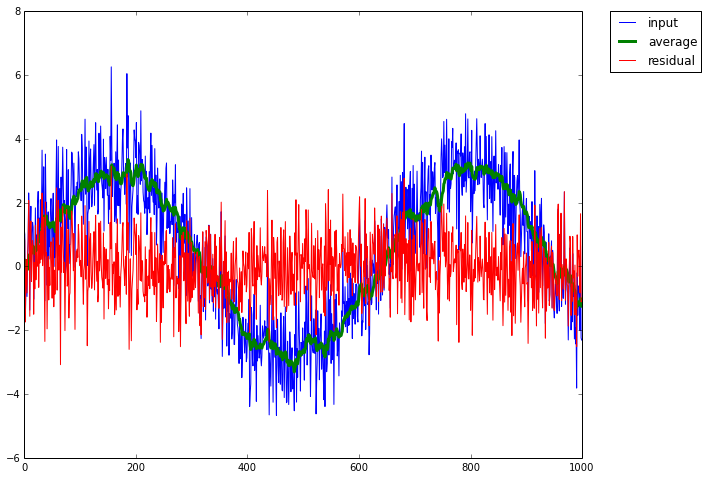

In [233] used 3.6172 MiB RAM in 0.47s, peaked 0.00 MiB above current, total RAM usage 198.98 MiB


In [233]:
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(A,label='input')
plt.plot(AV,linewidth=3.0,label='average')
plt.plot(R,label='residual')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**HW** explore the behaviour of the exponentially decaying average for square waves with wavelength of 10,100,1000.

### Estimating the standard deviation

In [238]:
# This coroutine assumes that the input it recieves has mean zero
@coroutine
def std_filter(target,alpha=0):
    n=0; s=0
    while True:
        (a,av,r)=(yield) # wait here to be get something sent.
        if(alpha==0):  # regular average
            n+=1
            s+=r*r
            std=math.sqrt(s/n)
            sr=r/std  # a: input, sqrt(s/n): std, sr: rescaled residual
            target.send((a,av,r,std,sr))
        else:  # Exponentially decaying average
            s=alpha*(r*r)+(1-alpha)*s
            std=math.sqrt(s)
            sr=r/std
            target.send((a,av,r,std,sr))

In [238] used 0.0039 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 199.05 MiB


In [243]:
sz=1000; scale=100.0
a=np.random.normal(loc=0,scale=1,size=sz) 
a= a+3*np.sin(np.arange(0,sz/scale,1/scale))
print len(a)

## 0.1 too large,  0.01 too small, 0.03 pretty good.
G=[]
Std=std_filter(collector(G),alpha=0.01)
Av=av_filter(Std,alpha=0.1)

for x in a:
    Av.send(x)

print len(G)

1000
1000
In [243] used 0.0508 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 211.00 MiB


In [244]:
A=[]; AV=[]; R=[]; STD=[]; SR=[];
for (a,av,r,std,sr) in G:
    A.append(a)
    AV.append(av)
    R.append(r)
    STD.append(std)
    SR.append(sr)

In [244] used 0.0117 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 211.02 MiB


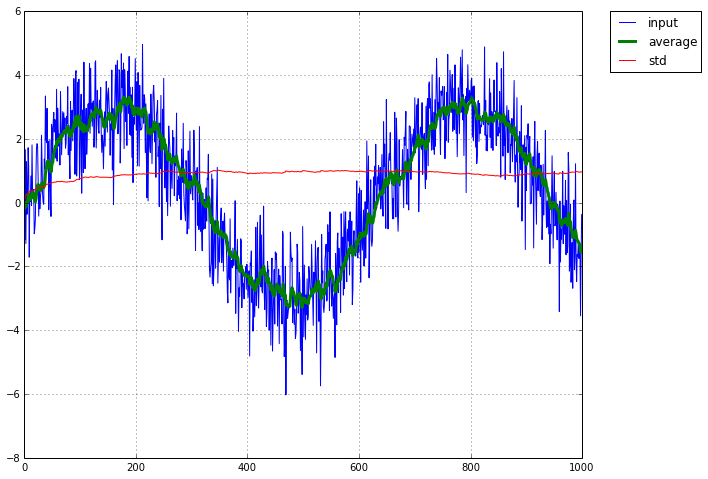

In [246] used 5.4102 MiB RAM in 0.47s, peaked 0.00 MiB above current, total RAM usage 219.96 MiB


In [246]:
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(A,label='input')
plt.plot(AV,linewidth=3.0,label='average')
#plt.plot(R,label='residual')
plt.plot(STD,label='std')
#plt.plot(SR,label='scaled residual')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

**HW** Leave the mean as it is and vary the standard deviation using a square wave. Observe what settings of alpha are needed for the average and for the std estimators.